## Lab 3: Where is the nearest cafe?

**Objectives:**
   * We will explore OpenStreetMap (OSM) data using <code>osmnx</code>.
   * Learn about OSM data stuctures
   * Compute walking distances using just a few lines of code
   * Visualize our data using `folium`

We will be relying heavily on <code>osmnx</code> which is a package that enables automatic download of geospatial data from OSM and allows us to model, project, visualize, and analyze real-world street networks. More information about this package can be found [here](https://osmnx.readthedocs.io/en/stable/) and the [GitHub repo](https://github.com/gboeing/osmnx/tree/6f9236f20a81416bf34186a811a8ebb76afa0dc8)

We will start with a simple example that calculates the Euclidean distance between Condon Hall and some cafes in Eugene. After that, we will use the <code>networkx</code> package to calculate actual walking distances from Condon Hall to the cafes.

### Check for any updates in course materials

Before we start this assignment, we need to check whether there are any updates to the original course repository. We can do this by adding the original repository (the one we forked) as a *remote*. Command line users can do this by running:

<code>git fetch upstream</code>

<code>git merge upstream/master master</code>

GitHub Desktop users should first click the **Fetch origin** button to check for new changes. Then click the triangle symbol next to **Current branch: main**, click **Choose a branch to merge into master**, click **upstream/main** from **Other branches** and click **Create a merge commit**. 

Any new updates to the course repository will now be available in your local repository.

### Create a new environment and launch the notebook

As always, make a new environment that contains all the packages for this lab. Navigate to the `labs/lab3` folder (either from the terminal for Linux and Mac users or from the **CMD.exe Prompt** launched from **Anaconda Navigator** for Windows users) and run:

`conda env create -f environment.yml`

Activate this environment by running:

`conda activate lab3`

Now launch the notebook by running:

`jupyter notebook 03_walking_distances.ipynb`

In [1]:
# Import modules
import osmnx as ox 

import numpy as np
import geopandas as gpd

from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import LineString, MultiLineString

### Retrieve OSM data

First we will retrieve all features labelled (or tagged) as buildings in Eugene.

In [2]:
# Specify type of data
tags = {'building': True}

# Download building geometries from OSM
gdf = ox.geometries_from_place('Eugene, Oregon, USA', tags)

C:\Users\Ian\AppData\Local\Temp\ipykernel_25100\46480968.py:5: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf = ox.geometries_from_place('Eugene, Oregon, USA', tags)


It did not take long to download all this data even though this GeoDataFrame is massive (don't worry about the error message!). We can find the number of buildings in Eugene by printing the shape of the GeoDataFrame.

In [3]:
print(gdf.shape)

(59971, 334)


We can find out what attributes are contained in this GeoDataFrame by printing the column headers as a list. 

In [4]:
print(gdf.columns.tolist())

['addr:state', 'building', 'ele', 'gnis:feature_id', 'name', 'operator', 'geometry', 'access', 'wheelchair', 'source', 'amenity', 'description', 'opening_hours', 'information', 'tourism', 'level', 'addr:housenumber', 'addr:postcode', 'addr:street', 'bus', 'network', 'public_transport', 'fee', 'leisure', 'sport', 'material', 'addr:city', 'check_date', 'emergency', 'man_made', 'website', 'takeaway', 'toilets', 'parking', 'brand', 'brand:wikidata', 'drive_through', 'indoor', 'operator:wikidata', 'layer', 'ref', 'height', 'nodes', 'addr:place', 'building:levels', 'contact:sms', 'internet_access', 'phone', 'shop', 'url', 'wikidata', 'wikipedia', 'atm', 'contact:website', 'fast_food', 'fuel:propane', 'name:ja', 'compressed_air', 'addr:unit', 'denomination', 'religion', 'government', 'office', 'tower:construction', 'tower:type', 'email', 'capacity', 'location', 'cuisine', 'delivery', 'payment:cash', 'payment:credit_cards', 'payment:debit_cards', 'start_date', 'internet_access:fee', 'internet_

Since OSM is entirely based on volunteered geographic information, there are a lot of attributes, most of which are not complete. We can find the number of non-NaNs in each column by typing:

In [5]:
# Count number of non-NaNs in each column
gdf.count()

addr:state             43397
building               59971
ele                       18
gnis:feature_id           19
name                    1331
                       ...  
fuel:gasoline_93           1
diet:non-vegetarian        1
ways                      88
type                      88
contact:tiktok             1
Length: 334, dtype: int64

For the purposes of this assignment, we are only interested in buildings that are tagged as **cafes**. Cafes are usually tagged as an **amenity** in OSM so we can filter them using a string comparison.

In [6]:
# Filter cafes
cafes = gdf[gdf['amenity'] == 'cafe'].reset_index()
cafes

,element_type,osmid,addr:state,building,ele,gnis:feature_id,name,operator,geometry,access,...,delivery:partner,service:vehicle:rv_repair,service:vehicle:trailers,service:vehicle:truck_repair,landuse,fuel:gasoline_93,diet:non-vegetarian,ways,type,contact:tiktok
0,way,123493968,OR,yes,NaN,NaN,The Human Bean,NaN,"POLYGON ((-123.14675 44.04824, -123.14675 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,way,221500325,NaN,retail,NaN,NaN,Brail's Espresso,NaN,"POLYGON ((-123.09262 44.04138, -123.09254 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,way,244977193,OR,yes,NaN,NaN,TopCity Frozen Yogurt Cafe,NaN,"POLYGON ((-123.11633 44.04085, -123.11633 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,way,244983219,OR,yes,NaN,NaN,Starbucks,NaN,"POLYGON ((-123.06465 44.04601, -123.06451 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,way,266746620,OR,commercial,NaN,NaN,Starbucks,NaN,"POLYGON ((-123.09120 44.02803, -123.09103 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,way,277456563,NaN,yes,NaN,NaN,Espresso Roma,NaN,"POLYGON ((-123.07985 44.04560, -123.07964 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,way,283863396,OR,yes,NaN,NaN,Dutch Bros. Coffee,NaN,"POLYGON ((-123.06118 44.04503, -123.06111 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,way,414520035,OR,yes,NaN,NaN,Romano's,NaN,"POLYGON ((-123.18510 44.08472, -123.18515 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,way,420982688,NaN,yes,NaN,NaN,Voodoo Doughnut,NaN,"POLYGON ((-123.09231 44.04983, -123.09242 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,way,421453808,OR,yes,NaN,NaN,Dutch Bros. Coffee,NaN,"POLYGON ((-123.08790 44.04789, -123.08790 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We find that there are 33 cafes in Eugene. This could well be an underestimate since there could be cafes that were not tagged as amenities when mapped. But let's keep moving forward. 

### Computing Euclidean distances to cafes from Condon Hall

We now want to compute the distance to ten nearest cafes. First we will have to reproject our data to UTM Zone 10N which is a projection system that contains Oregon (https://epsg.io/32610)

In [7]:
# Reproject to UTM Zone 10N
gdf = gdf.to_crs('EPSG:32610')
cafes = cafes.to_crs('EPSG:32610')

Find the coordinates of Condon Hall by searching for **Condon Hall** in the original GeoDataFrame.

In [8]:
# Get coordinates of Condon Hall
condon_hall = gdf[gdf['name'] == 'Condon Hall'].reset_index()

Compute building centroids so we can compute point-to-point distances.

In [9]:
# Get cafe and Condon Hall centroids
cafes['centroid'] = cafes['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

condon_hall['centroid'] = condon_hall['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

Now we can compute the Euclidean distances between Condon Hall and the cafes

In [10]:
# Compute distances
condon_hall_x = condon_hall['centroid'].x.values[0]
condon_hall_y = condon_hall['centroid'].y.values[0]
distances = np.sqrt(((condon_hall_x - cafes['centroid'].x.values)**2)
                     + ((condon_hall_y - cafes['centroid'].y.values)**2))

# Add to GeoDataFrame
cafes['euclidean_distance'] = distances

...and print a list of the ten closest cafes to Condon Hall

In [11]:
print(cafes.nsmallest(10, ['euclidean_distance'])[['name', 'euclidean_distance']])

                            name  euclidean_distance
5                  Espresso Roma          135.288663
9             Dutch Bros. Coffee          830.864189
3                      Starbucks         1094.038306
10                        Palace         1115.624529
1               Brail's Espresso         1225.005794
8                Voodoo Doughnut         1240.797103
15                 Amazon Coffee         1296.504962
6             Dutch Bros. Coffee         1369.368652
31            Dutch Bros. Coffee         1519.720322
25  The Quick Fix Coffee Company         1844.810972


Now for a bit of magic, let's visualize our data using `folium`

In [12]:
# Make a new DataFrame containing only the three most relevant columns
nearest_cafes = cafes.nsmallest(10, ['euclidean_distance'])[['name', 'euclidean_distance', 'centroid']]

# Set column geometry
nearest_cafes = nearest_cafes.set_geometry('centroid')

# Convert back to WGS84
nearest_cafes = nearest_cafes.to_crs('EPSG:4326')

# Import package
import folium

# Define center of map (i.e. Condon Hall) and initial zoom level
lat_lon = [44.0451, -123.0781]
m = folium.Map(location=lat_lon, zoom_start=15)

for i in range(0, nearest_cafes.shape[0]):
    my_string = 'name: {}, distance: {}'.format(nearest_cafes.iloc[i]['name'], nearest_cafes.iloc[i]['euclidean_distance'])
    folium.Marker([nearest_cafes.iloc[i]['centroid'].y, nearest_cafes.iloc[i]['centroid'].x],
                 popup=my_string).add_to(m)

# Display map
m

Click on the markers above and a pop-up should appear showing the name of the cafe and Euclidean distance (in meters) from Condon Hall.

## Question 1 (20 points):
Write a script that:

* Computes the Euclidean distance to another **amenity** of your choosing (HINT: use `gdf['amenity'].unique()` to list the different amenities). Feel free to download OSM buildings from another place and choose a different home' location.


* Makes an interactive map showing where your ten nearest amenities are using `folium`. 

In [13]:
gdf['amenity'].unique()

array([nan, 'restaurant', 'fuel', 'fire_station', 'place_of_worship',
       'cafe', 'fast_food', 'library', 'shelter', 'bank', 'studio',
       'dentist', 'social_facility', 'pub', 'college',
       'conference_centre', 'community_centre', 'police', 'parking',
       'cinema', 'doctors', 'post_office', 'theatre', 'clinic', 'prison',
       'courthouse', 'veterinary', 'townhall', 'music_school', 'bar',
       'arts_centre', 'car_wash', 'training', 'animal_shelter', 'toilets',
       'biergarten', 'childcare', 'bicycle_parking', 'bus_station',
       'recycling', 'car_rental', 'marketplace', 'kindergarten', 'school',
       'hospital', 'events_venue', 'social_centre', 'ice_cream'],
      dtype=object)

In [14]:
# Filter libraries
libraries = gdf[gdf['amenity'] == 'library'].reset_index()
# gdf already reprojected, so don't need to reproject libraries
libraries

,element_type,osmid,addr:state,building,ele,gnis:feature_id,name,operator,geometry,access,...,delivery:partner,service:vehicle:rv_repair,service:vehicle:trailers,service:vehicle:truck_repair,landuse,fuel:gasoline_93,diet:non-vegetarian,ways,type,contact:tiktok
0,way,155170317,OR,yes,NaN,NaN,Knight Library,NaN,"POLYGON ((493753.973 4876726.489, 493760.718 4...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,way,283891483,NaN,government,NaN,NaN,Eugene Public Library,City of Eugene,"POLYGON ((492433.070 4877250.727, 492433.007 4...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,way,794483713,OR,yes,NaN,NaN,Bethel Branch Library,NaN,"POLYGON ((486409.303 4881245.601, 486409.255 4...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
libraries['centroid'] = libraries['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

In [16]:
distances = np.sqrt(((condon_hall_x - libraries['centroid'].x.values)**2)
                     + ((condon_hall_y - libraries['centroid'].y.values)**2))

In [17]:
libraries['euclidean_distance'] = distances

In [18]:
print(libraries.nsmallest(10, ['euclidean_distance'])[['name', 'euclidean_distance']])

                    name  euclidean_distance
0         Knight Library          220.549886
1  Eugene Public Library         1389.093415
2  Bethel Branch Library         8509.226411


# <span style='color:red'>Ian's Notes</span>
Some ammenities have less than 10 instances.

In [19]:
# Filter libraries
fast_food = gdf[gdf['amenity'] == 'fast_food'].reset_index()
# gdf already reprojected, so don't need to reproject libraries
fast_food

,element_type,osmid,addr:state,building,ele,gnis:feature_id,name,operator,geometry,access,...,delivery:partner,service:vehicle:rv_repair,service:vehicle:trailers,service:vehicle:truck_repair,landuse,fuel:gasoline_93,diet:non-vegetarian,ways,type,contact:tiktok
0,way,123493969,OR,yes,NaN,NaN,Carl's Jr.,NaN,"POLYGON ((488169.662 4877241.918, 488181.718 4...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,way,215635196,OR,yes,NaN,NaN,Taco Time,NaN,"POLYGON ((492437.399 4882282.652, 492448.326 4...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,way,221685107,OR,yes,NaN,NaN,Papa John's,NaN,"POLYGON ((492662.223 4874756.433, 492662.414 4...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,way,266746621,OR,commercial,NaN,NaN,Chipotle,NaN,"POLYGON ((492682.816 4874942.305, 492689.388 4...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,way,277755625,NaN,yes,NaN,NaN,Burrito Boy,NaN,"POLYGON ((493222.470 4877404.100, 493222.011 4...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,way,283548001,OR,yes,NaN,NaN,Laughing Planet,NaN,"POLYGON ((491520.027 4877606.269, 491519.999 4...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,way,311036526,OR,yes,NaN,NaN,Taco Bell,NaN,"POLYGON ((490086.776 4882853.346, 490081.931 4...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,way,311036528,OR,yes,NaN,NaN,Burger King,NaN,"POLYGON ((489762.121 4882910.344, 489762.072 4...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,way,311038546,OR,yes,NaN,NaN,Carl's Jr.,NaN,"POLYGON ((489718.614 4882537.894, 489718.541 4...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,way,311038547,OR,commercial,NaN,NaN,Arby's,NaN,"POLYGON ((489694.319 4882562.323, 489694.345 4...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
fast_food['centroid'] = fast_food['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

In [21]:
distances = np.sqrt(((condon_hall_x - fast_food['centroid'].x.values)**2)
                     + ((condon_hall_y - fast_food['centroid'].y.values)**2))
fast_food['euclidean_distance'] = distances

In [22]:
print(fast_food.nsmallest(10, ['euclidean_distance'])[['name', 'euclidean_distance']])

                         name  euclidean_distance
15           DQ Grill & Chill          294.217077
16                 McDonald's          686.779722
4                 Burrito Boy          715.080098
25  Los Dos Hermanos Taqueria         1223.839310
19                   Domino's         1927.349279
30                     Subway         1953.389487
3                    Chipotle         2204.484695
35                 McDonald's         2251.986282
5             Laughing Planet         2314.838575
20                 Carl's Jr.         2331.944539


In [23]:
# Make a new DataFrame containing only the three most relevant columns
nearest_fast_food = fast_food.nsmallest(10, ['euclidean_distance'])[['name', 'euclidean_distance', 'centroid']]

# Set column geometry
nearest_fast_food = nearest_fast_food.set_geometry('centroid')

# Convert back to WGS84
nearest_fast_food = nearest_fast_food.to_crs('EPSG:4326')

# Import package
import folium

# Define center of map (i.e. Condon Hall) and initial zoom level
lat_lon = [44.0451, -123.0781]
m = folium.Map(location=lat_lon, zoom_start=15)

for i in range(0, nearest_fast_food.shape[0]):
    my_string = 'name: {}, distance: {}'.format(nearest_fast_food.iloc[i]['name'], nearest_fast_food.iloc[i]['euclidean_distance'])
    folium.Marker([nearest_fast_food.iloc[i]['centroid'].y, nearest_fast_food.iloc[i]['centroid'].x],
                 popup=my_string).add_to(m)

# Display map
m

### Computing network distances

Euclidean distances often underestimate the distance between two objects, especially when there are obstacles between the two. So we will now compute some more realistic distances to cafes around Condon Hall. First we will need to import the [<code>networkx</code>](https://networkx.org/) package which will allow us conduct a network analysis. 

In [24]:
# Import module
import networkx as nx

Now we will define the coordinates of Condon Hall and download a walkable street network from OSM. Since the furthest of our ten cafes was 1.5 km away, we will limit our download to 1.6 km.

C:\Users\Ian\anaconda3\envs\lab3\lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


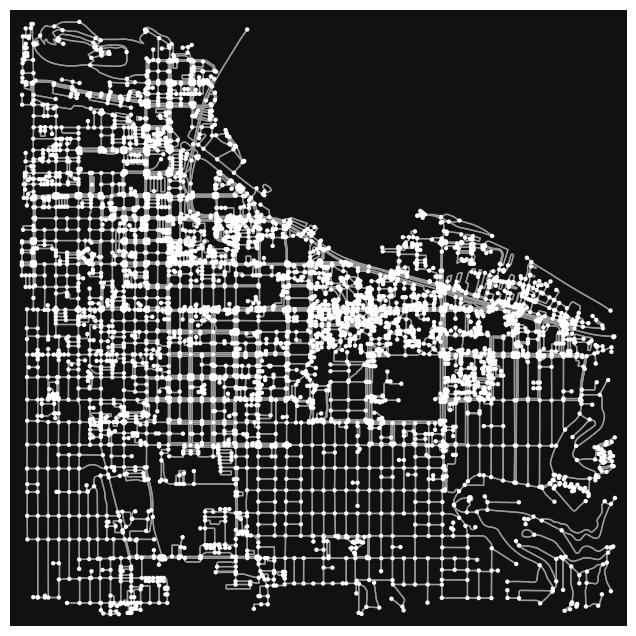

In [25]:
# Define coordinates of Condon Hall
lat_lon = (44.0451, -123.0781)

# Import walkable street network data around Condon Hall
g = ox.graph_from_point(lat_lon, dist=1600, network_type='walk')

# Plot map
fig, ax = ox.plot_graph(g, node_size=10)

In [26]:
# Convert to graph
graph_proj = ox.project_graph(g)

# Get edges and nodes separately
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [27]:
# Check projection is UTM Zone 10N
print("Coordinate system:", edges_proj.crs)

# Convert the cafe dataset back to UTM Zone 10N
nearest_cafes = nearest_cafes.to_crs('EPSG:32610')

Coordinate system: EPSG:32610


In [28]:
# Get x and y coordinates of Condon Hall
orig_xy = (condon_hall['centroid'].y.values[0], condon_hall['centroid'].x.values[0])

# Get x and y coordinates of one of the cafes (the furthest of the ten)
target_xy = (nearest_cafes['centroid'].y.values[-1], nearest_cafes['centroid'].x.values[-1])

In [29]:
# Find the node in the graph that is closest to the origin point (here, we want to get the node id)
orig_node = ox.distance.nearest_nodes(G=graph_proj, X=orig_xy[1], Y=orig_xy[0], return_dist=False)

# Find the node in the graph that is closest to the target point (here, we want to get the node id)
target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1], Y=target_xy[0], return_dist=False)

In [30]:
# Calculate the shortest path
route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')

In [31]:
# Plot the shortest path using folium
m = ox.plot_route_folium(g, route, weight=5)
m

C:\Users\Ian\AppData\Local\Temp\ipykernel_25100\421648342.py:2: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  m = ox.plot_route_folium(g, route, weight=5)


## Question 2 (20 points): 

Adapt the code above to compute the network distance between two points (either in Eugene or in a city of your choice) and show your results using an interactive map. Write a few sentences about what your map shows.

In [70]:
gdf = gdf.to_crs('EPSG:32610')

In [71]:
restaurants = gdf[gdf['amenity'] == 'restaurant'].reset_index()
restaurants['centroid'] = restaurants['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

In [72]:
public_library = gdf[gdf['name'] == 'Eugene Public Library'].reset_index()
public_library['centroid'] = public_library['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

In [73]:
publib_x = public_library['centroid'].x.values[0]
publib_y = public_library['centroid'].y.values[0]

distances = np.sqrt(((publib_x - restaurants['centroid'].x.values)**2)
                     + ((publib_y - restaurants['centroid'].y.values)**2))
restaurants['euclidean_distance'] = distances

nearest_restaurants = restaurants.nsmallest(10, ['euclidean_distance'])[['name', 'euclidean_distance', 'centroid']]

In [74]:
nearest_restaurants

,name,euclidean_distance,centroid
32,Viva! Vegetarian Grill,276.501466,POINT (492589.396 4877069.610)
73,Albee's NY Gyros,298.027814,POINT (492105.501 4877194.378)
31,Ta Ra Rin,349.443994,POINT (492667.511 4877047.551)
24,Ambrosia Restaurant & Bar,402.910762,POINT (492777.429 4877392.215)
33,Bill & Tim's Barbeque,535.857408,POINT (492833.314 4876958.073)
37,Krob Krua,567.544472,POINT (492835.208 4876908.068)
50,Mandy's Family Restaurant,581.871342,POINT (492590.799 4876718.167)
46,Bar Purlieu,640.980260,POINT (492541.111 4876641.975)
44,Toshi's Ramen,722.594883,POINT (492779.034 4876654.068)
0,Scribles Bistro & Deli,784.936348,POINT (491620.794 4877135.419)


In [75]:
tenth_nearest_restaurant = nearest_restaurants[nearest_restaurants['euclidean_distance'] == nearest_restaurants['euclidean_distance'].max()]
tenth_nearest_restaurant

,name,euclidean_distance,centroid
0,Scribles Bistro & Deli,784.936348,POINT (491620.794 4877135.419)


(44.04851798457641, -123.09493610110101)


C:\Users\Ian\anaconda3\envs\lab3\lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


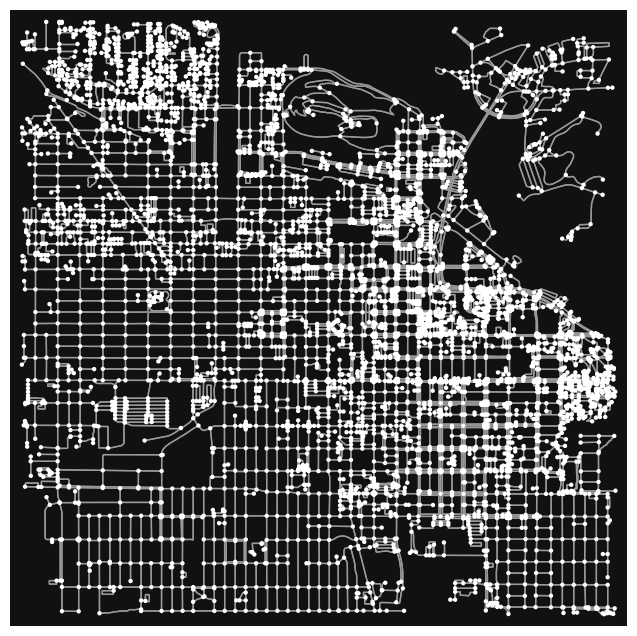

In [76]:
# Convert back to WGS84
public_library = public_library.set_geometry('centroid')
tenth_nearest_restaurant = tenth_nearest_restaurant.set_geometry('centroid')

tenth_nearest_restaurant = tenth_nearest_restaurant.to_crs('EPSG:4326')
public_library = public_library.to_crs('EPSG:4326')

publib_x = public_library['centroid'].x.values[0]
publib_y = public_library['centroid'].y.values[0]

scribles_x = tenth_nearest_restaurant['centroid'].x.values[0]
scribles_y = tenth_nearest_restaurant['centroid'].y.values[0]

lat_lon = (publib_y, publib_x)
print(lat_lon)

g = ox.graph_from_point(lat_lon, dist=1600, network_type='walk')

# Plot map
fig, ax = ox.plot_graph(g, node_size=10)

In [77]:
# Convert to graph
graph_proj = ox.project_graph(g)

# Get edges and nodes separately
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [84]:
# Check projection is UTM Zone 10N
print("Coordinate system:", edges_proj.crs)

# Convert the cafe dataset back to UTM Zone 10N
tenth_nearest_restaurant = tenth_nearest_restaurant.to_crs('EPSG:32610')
public_library = public_library.to_crs('EPSG:32610')

Coordinate system: EPSG:32610


In [85]:
# Get x and y coordinates of Condon Hall
orig_xy = (public_library['centroid'].y.values[0], public_library['centroid'].x.values[0])

# Get x and y coordinates of one of the cafes (the furthest of the ten)
target_xy = (tenth_nearest_restaurant['centroid'].y.values[0], tenth_nearest_restaurant['centroid'].x.values[0])

In [86]:
# Find the node in the graph that is closest to the origin point (here, we want to get the node id)
orig_node = ox.distance.nearest_nodes(G=graph_proj, X=orig_xy[1], Y=orig_xy[0], return_dist=False)

# Find the node in the graph that is closest to the target point (here, we want to get the node id)
target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1], Y=target_xy[0], return_dist=False)

In [87]:
# Calculate the shortest path
route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')

In [88]:
# Plot the shortest path using folium
m = ox.plot_route_folium(g, route, weight=5)
m

C:\Users\Ian\AppData\Local\Temp\ipykernel_25100\421648342.py:2: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  m = ox.plot_route_folium(g, route, weight=5)


The map shows the shortest walkable path between the Eugene Public Library, and the 10th closest building under the 'restaurants' category (Scrible's Bistro and Deli). Or, more accurately, it shows the shortest path between the nearest viable graph nodes to those locations. The Scrible's end of the path is on the street corner closest to Scrible's, which itself is closer to the midpoint between two intersections.

### Compute network distances between Condon Hall and cafes

In [89]:
# Get the nodes along the shortest path
route_nodes = nodes_proj.loc[route]

# Create a geometry for the shortest path
route_line = LineString(list(route_nodes['geometry'].values))

# Create a GeoDataFrame
route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

# Print length of route
print('Walking distance to %s = %.1f km' % (nearest_cafes['name'].iloc[-1], route_geom['geometry'].length / 1000))

Walking distance to The Quick Fix Coffee Company = 0.9 km


C:\Users\Ian\AppData\Local\Temp\ipykernel_25100\1890859705.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Walking distance to %s = %.1f km' % (nearest_cafes['name'].iloc[-1], route_geom['geometry'].length / 1000))


OK that looks very nice, but what about if we wanted distances to all ten cafes. We need to put this code into a for loop.

In [90]:
# Get x and y coordinates of all ten of the nearest cafes
target_xy = (nearest_cafes['centroid'].y.values, nearest_cafes['centroid'].x.values)

In [91]:
routes = []
distances = []
for i in range(len(target_xy[0])):
    
    # Find the node in the graph that is closest to the target point (here, we want to get the node id)
    target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1][i], Y=target_xy[0][i], return_dist=False)
    
    # Calculate the shortest path
    route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')
    
    # Append route to list
    routes.append(route)
    
    # Get the nodes along the shortest path
    route_nodes = nodes_proj.loc[route]
    
    # Create a geometry for the shortest path
    route_line = LineString(list(route_nodes['geometry'].values))

    # Create a GeoDataFrame
    route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

    # Print length of route
    print('Walking distance to %s = %.1f km' % (nearest_cafes['name'].iloc[i], route_geom['geometry'].length / 1000))
    
    # Append distances to list
    distances.append(route_geom['geometry'].length[0])

C:\Users\Ian\AppData\Local\Temp\ipykernel_25100\4114944270.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Walking distance to %s = %.1f km' % (nearest_cafes['name'].iloc[i], route_geom['geometry'].length / 1000))
C:\Users\Ian\AppData\Local\Temp\ipykernel_25100\4114944270.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Walking distance to %s = %.1f km' % (nearest_cafes['name'].iloc[i], route_geom['geometry'].length / 1000))
C:\Users\Ian\AppData\Local\Temp\ipykernel_25100\4114944270.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Walking distance to %s = %.1f km' % (nearest_cafes['name'].iloc[i], route_geom['geometry'].length / 1000))
C:\Users\Ian\AppData\Loca

Walking distance to Espresso Roma = 1.5 km
Walking distance to Dutch Bros. Coffee = 0.6 km
Walking distance to Starbucks = 1.9 km
Walking distance to Palace = 0.7 km


C:\Users\Ian\AppData\Local\Temp\ipykernel_25100\4114944270.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Walking distance to %s = %.1f km' % (nearest_cafes['name'].iloc[i], route_geom['geometry'].length / 1000))
C:\Users\Ian\AppData\Local\Temp\ipykernel_25100\4114944270.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Walking distance to %s = %.1f km' % (nearest_cafes['name'].iloc[i], route_geom['geometry'].length / 1000))
C:\Users\Ian\AppData\Local\Temp\ipykernel_25100\4114944270.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Walking distance to %s = %.1f km' % (nearest_cafes['name'].iloc[i], route_geom['geometry'].length / 1000))
C:\Users\Ian\AppData\Loca

Walking distance to Brail's Espresso = 1.0 km
Walking distance to Voodoo Doughnut = 0.5 km
Walking distance to Amazon Coffee = 1.0 km
Walking distance to Dutch Bros. Coffee = 1.9 km
Walking distance to Dutch Bros. Coffee = 0.5 km
Walking distance to The Quick Fix Coffee Company = 1.8 km


C:\Users\Ian\AppData\Local\Temp\ipykernel_25100\4114944270.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Walking distance to %s = %.1f km' % (nearest_cafes['name'].iloc[i], route_geom['geometry'].length / 1000))
C:\Users\Ian\AppData\Local\Temp\ipykernel_25100\4114944270.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Walking distance to %s = %.1f km' % (nearest_cafes['name'].iloc[i], route_geom['geometry'].length / 1000))


Let's add the network distances to the original DataFrame and display

In [92]:
nearest_cafes['network_distance'] = distances
nearest_cafes

,name,euclidean_distance,centroid,network_distance
5,Espresso Roma,135.288663,POINT (493611.907 4876951.876),1494.359427
9,Dutch Bros. Coffee,830.864189,POINT (492960.549 4877198.252),635.285880
3,Starbucks,1094.038306,POINT (494822.753 4876971.001),1858.333172
10,Palace,1115.624529,POINT (492791.711 4877489.898),650.685853
1,Brail's Espresso,1225.005794,POINT (492582.859 4876464.165),953.302784
8,Voodoo Doughnut,1240.797103,POINT (492600.687 4877399.263),457.647736
15,Amazon Coffee,1296.504962,POINT (492548.799 4876358.612),1042.280183
6,Dutch Bros. Coffee,1369.368652,POINT (495101.061 4876873.629),1858.333172
31,Dutch Bros. Coffee,1519.720322,POINT (492413.072 4877644.513),507.072287
25,The Quick Fix Coffee Company,1844.810972,POINT (492747.353 4875328.957),1785.192734


# <span style='color:red'>Ian's Notes</span>

A lot of future warnings appear when running the example code (see red-highlighted text warnings throughout this notebook). Consider updating example code.

## Question 3 (10 points): 


* a) Calculate the average difference between the Euclidean and network distances for you amenities 


* b) Describe some situations where it would not be advisable to use Euclidean distances?

### (a)

In [94]:
target_xy = (nearest_restaurants['centroid'].y.values, nearest_restaurants['centroid'].x.values)

routes = []
distances = []
for i in range(len(target_xy[0])):
    
    # Find the node in the graph that is closest to the target point (here, we want to get the node id)
    target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1][i], Y=target_xy[0][i], return_dist=False)
    
    # Calculate the shortest path
    route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')
    
    # Append route to list
    routes.append(route)
    
    # Get the nodes along the shortest path
    route_nodes = nodes_proj.loc[route]
    
    # Create a geometry for the shortest path
    route_line = LineString(list(route_nodes['geometry'].values))

    # Create a GeoDataFrame
    route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

    # Print length of route
    print('Walking distance to %s = %.1f km' % (nearest_restaurants['name'].iloc[i], route_geom['geometry'].length / 1000))
    
    # Append distances to list
    distances.append(route_geom['geometry'].length[0])

C:\Users\Ian\AppData\Local\Temp\ipykernel_25100\386535567.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Walking distance to %s = %.1f km' % (nearest_restaurants['name'].iloc[i], route_geom['geometry'].length / 1000))
C:\Users\Ian\AppData\Local\Temp\ipykernel_25100\386535567.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Walking distance to %s = %.1f km' % (nearest_restaurants['name'].iloc[i], route_geom['geometry'].length / 1000))
C:\Users\Ian\AppData\Local\Temp\ipykernel_25100\386535567.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Walking distance to %s = %.1f km' % (nearest_restaurants['name'].iloc[i], route_geom['geometry'].length / 1000))
C:\Users\I

Walking distance to Viva! Vegetarian Grill = 0.3 km
Walking distance to Albee's NY Gyros = 0.4 km
Walking distance to Ta Ra Rin = 0.5 km
Walking distance to Ambrosia Restaurant & Bar = 0.6 km
Walking distance to Bill & Tim's Barbeque = 0.7 km
Walking distance to Krob Krua = 0.7 km
Walking distance to Mandy's Family Restaurant = 0.8 km
Walking distance to Bar Purlieu = 0.8 km
Walking distance to Toshi's Ramen = 1.0 km
Walking distance to Scribles Bistro & Deli = 0.9 km


C:\Users\Ian\AppData\Local\Temp\ipykernel_25100\386535567.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Walking distance to %s = %.1f km' % (nearest_restaurants['name'].iloc[i], route_geom['geometry'].length / 1000))
C:\Users\Ian\AppData\Local\Temp\ipykernel_25100\386535567.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Walking distance to %s = %.1f km' % (nearest_restaurants['name'].iloc[i], route_geom['geometry'].length / 1000))
C:\Users\Ian\AppData\Local\Temp\ipykernel_25100\386535567.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Walking distance to %s = %.1f km' % (nearest_restaurants['name'].iloc[i], route_geom['geometry'].length / 1000))
C:\Users\I

In [95]:
nearest_restaurants['network_distance'] = distances
nearest_restaurants

,name,euclidean_distance,centroid,network_distance
32,Viva! Vegetarian Grill,276.501466,POINT (492589.396 4877069.610),337.539177
73,Albee's NY Gyros,298.027814,POINT (492105.501 4877194.378),361.068923
31,Ta Ra Rin,349.443994,POINT (492667.511 4877047.551),461.053638
24,Ambrosia Restaurant & Bar,402.910762,POINT (492777.429 4877392.215),555.867995
33,Bill & Tim's Barbeque,535.857408,POINT (492833.314 4876958.073),688.450252
37,Krob Krua,567.544472,POINT (492835.208 4876908.068),749.028351
50,Mandy's Family Restaurant,581.871342,POINT (492590.799 4876718.167),752.537980
46,Bar Purlieu,640.980260,POINT (492541.111 4876641.975),767.542799
44,Toshi's Ramen,722.594883,POINT (492779.034 4876654.068),950.807732
0,Scribles Bistro & Deli,784.936348,POINT (491620.794 4877135.419),913.245615


In [97]:
nearest_restaurants['diff_distance'] = nearest_restaurants['network_distance'] - nearest_restaurants['euclidean_distance']
nearest_restaurants['diff_distance'].mean()

137.64737154363675

### (b)

Network distance is best when movement is largely restricted to a network or grid of traversable channels (roads in this case), with relatively little freedom of movement outside of these channels. Euclidean distance works with environments with unrestricted or minimally-restricted movement.

## Remember to submit your answers to Questions 1, 2 and 3 **by Friday 11:59pm**